## **Import Libraries**

In [125]:
# Data wrangling 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data Loading**

In [257]:
anz_df=pd.read_excel('/content/drive/MyDrive/ANZ synthesised transaction dataset.xlsx')

In [128]:
anz_df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


### **Feature Engineering**
Compute the annual salary for each customer and create features that can help us predict the annual salaries.

First, we will make the annual salary the target variable that we are supposed to predict using a model.


In [129]:
salary_df=pd.DataFrame({"customer_id": anz_df.customer_id.unique()})

In [130]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = anz_df.loc[(anz_df.customer_id == salary_df.customer_id[customer]) & (anz_df.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount       
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


### **Predictor Variables**
Age, gender, average number of weekly transactions,maximum transaction amount, most frequently transacted amount, median balance, average expenditure, different transaction types are used as independent features in this prediction.
These features where chosen, and their correlation to each other was determined, which was used to intuit whether the selected(and created) features could be predictive.

In [131]:
# Unique customer id's 
unique_id = anz_df.customer_id.unique()
len(unique_id)

100

In [138]:
!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Since, a significant number of the features are categorical variable, determining the correlation of only the numeric values wasn't enough. So, the dpython library is used to demonstrate correlation using heatmaps.

In [139]:
import pandas as pd
from dython.nominal import associations

In [140]:
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(anz_df)
categorical_features

['status',
 'bpay_biller_code',
 'account',
 'currency',
 'long_lat',
 'txn_description',
 'merchant_id',
 'first_name',
 'gender',
 'merchant_suburb',
 'merchant_state',
 'extraction',
 'transaction_id',
 'country',
 'customer_id',
 'merchant_long_lat',
 'movement']

In [258]:
correlatable_features=anz_df[['status','age', 'card_present_flag', 'balance', 'amount', 
                             
 'bpay_biller_code',
 'long_lat',
 'txn_description',
 'gender',
 'merchant_suburb',
 'merchant_state',
 'merchant_long_lat',
 'movement']]

In [254]:
correlatable_features.head()

,status,age,card_present_flag,balance,amount,bpay_biller_code,long_lat,txn_description,gender,merchant_suburb,merchant_state,merchant_long_lat,movement
50,posted,23,NaN,8342.11,3903.95,0,151.27 -33.76,PAY/SALARY,M,NaN,NaN,NaN,credit
61,posted,23,NaN,2040.58,1626.48,0,145.01 -37.93,PAY/SALARY,F,NaN,NaN,NaN,credit
64,posted,22,NaN,3158.51,983.36,0,151.18 -33.80,PAY/SALARY,M,NaN,NaN,NaN,credit
68,posted,24,NaN,2517.66,1408.08,0,145.00 -37.83,PAY/SALARY,M,NaN,NaN,NaN,credit
70,posted,43,NaN,2271.79,1068.04,0,144.95 -37.76,PAY/SALARY,F,NaN,NaN,NaN,credit


In [143]:
anz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

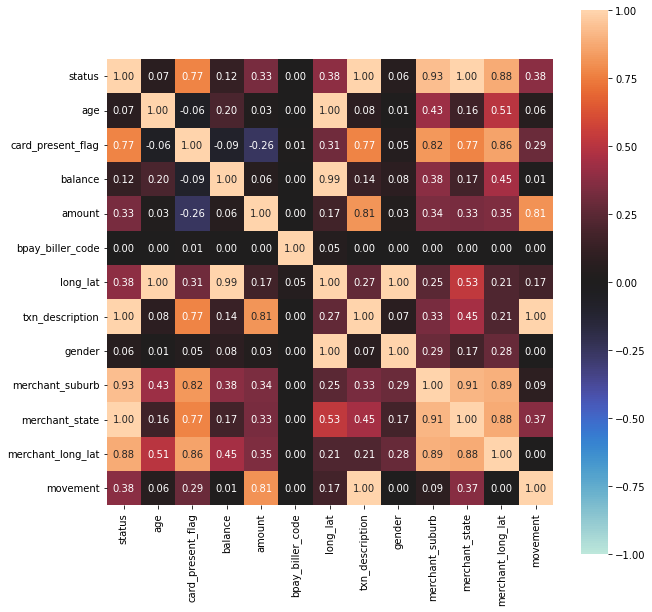

In [259]:
complete_correlation= associations(correlatable_features, filename= 'complete_correlation.png', figsize=(10,10))

In [145]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,status,age,card_present_flag,balance,amount,bpay_biller_code,long_lat,txn_description,gender,merchant_suburb,merchant_state,merchant_long_lat,movement
status,1.00,0.07,0.77,0.12,0.33,0.00,0.38,1.00,0.06,0.93,1.00,0.88,0.00
age,0.07,1.00,-0.06,0.20,0.03,0.00,1.00,0.08,0.01,0.43,0.16,0.51,0.00
card_present_flag,0.77,-0.06,1.00,-0.09,-0.26,0.01,0.31,0.77,0.05,0.82,0.77,0.86,0.00
balance,0.12,0.20,-0.09,1.00,0.06,0.00,0.99,0.14,0.08,0.38,0.17,0.45,0.00
amount,0.33,0.03,-0.26,0.06,1.00,0.00,0.17,0.81,0.03,0.34,0.33,0.35,0.00
bpay_biller_code,0.00,0.00,0.01,0.00,0.00,1.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00
long_lat,0.38,1.00,0.31,0.99,0.17,0.05,1.00,0.27,1.00,0.25,0.53,0.21,0.00
txn_description,1.00,0.08,0.77,0.14,0.81,0.00,0.27,1.00,0.07,0.33,0.45,0.21,0.00
gender,0.06,0.01,0.05,0.08,0.03,0.00,1.00,0.07,1.00,0.29,0.17,0.28,0.00
merchant_suburb,0.93,0.43,0.82,0.38,0.34,0.00,0.25,0.33,0.29,1.00,0.91,0.89,0.00


From the above heatmaps, we can see that most of the features aren't well related, 

In [146]:
import scipy.stats as ss
import math
from collections import Counter
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

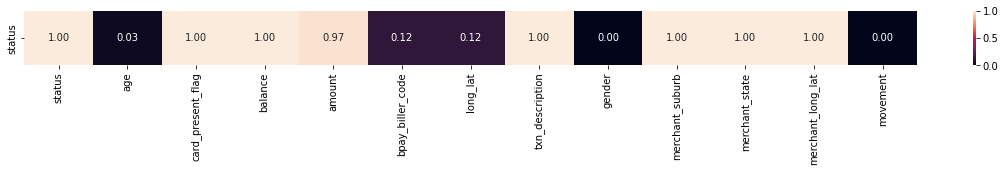

In [147]:
theilu = pd.DataFrame(index=['status'],columns=correlatable_features.columns)
columns = correlatable_features.columns
for j in range(0,len(columns)):
    u = theils_u(correlatable_features['status'].tolist(),correlatable_features[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

In [148]:
#Finding the Salary for all the customers
salary=anz_df[anz_df["txn_description"]=="PAY/SALARY"].groupby("customer_id").mean().reset_index()
salary=salary[["customer_id","amount"]]
salary=salary.rename(columns = {'amount':'salary'})

In [149]:
salary.head()

,customer_id,salary
0,CUS-1005756958,970.47
1,CUS-1117979751,3578.65
2,CUS-1140341822,1916.51
3,CUS-1147642491,1711.39
4,CUS-1196156254,3903.73


### **Creating new features**

In [150]:
#POS indicates transaction made at any business or such, thus it reflects spending behaviour of customer
pos=anz_df[anz_df["txn_description"]==("POS"or"SALES-POS")].groupby("customer_id").median().reset_index()
pos=pos[["customer_id","amount"]]
pos=pos.rename(columns = {'amount':'pos'})

In [151]:
pos.head()

,customer_id,pos
0,CUS-1005756958,21.290
1,CUS-1117979751,20.305
2,CUS-1140341822,18.940
3,CUS-1147642491,38.075
4,CUS-1196156254,21.955


In [152]:
#Bills and payments made by customer
payment=anz_df[anz_df["txn_description"]=="PAYMENT"].groupby("customer_id").median().reset_index()
payment=payment[["customer_id","amount"]]
payment=payment.rename(columns = {'amount':'payment'})

In [153]:
payment.head()

,customer_id,payment
0,CUS-1005756958,148.0
1,CUS-1117979751,55.0
2,CUS-1140341822,142.0
3,CUS-1147642491,79.0
4,CUS-1196156254,31.0


In [154]:
#interbank, bank to bank transfer made by the customer
inter_bank=anz_df[anz_df["txn_description"]=="INTER BANK"].groupby("customer_id").median().reset_index()
inter_bank=inter_bank[["customer_id","amount"]]
inter_bank=inter_bank.rename(columns = {'amount':'interbank'})

In [155]:
len(inter_bank)

68

In [156]:
#Banking via phone/online pay
phonebank=anz_df[anz_df["txn_description"]=='PHONE BANK'].groupby("customer_id").median().reset_index()
phonebank=phonebank[["customer_id","amount"]]
phonebank=phonebank.rename(columns = {'amount':'phonebank'})

In [157]:
phonebank

,customer_id,phonebank
0,CUS-1005756958,182.0
1,CUS-1646183815,150.0
2,CUS-1896554896,1916.0
3,CUS-2155701614,82.0
4,CUS-2348881191,1629.0
5,CUS-2376382098,177.0
6,CUS-261674136,43.0
7,CUS-3151318058,36.0
8,CUS-3180318393,67.0
9,CUS-326006476,158.0


In [158]:
# gender=pd.DataFrame(anz_df['customer_id'].unique(), columns=['customer_id'])
gender=anz_df.groupby('customer_id')['gender'].first().to_frame('gender').reset_index()
gender
# phonebank=phonebank.rename(columns = {'amount':'phonebank'})

,customer_id,gender
0,CUS-1005756958,F
1,CUS-1117979751,M
2,CUS-1140341822,M
3,CUS-1147642491,F
4,CUS-1196156254,F
...,...,...
95,CUS-72755508,F
96,CUS-809013380,F
97,CUS-860700529,M
98,CUS-880898248,M


In [167]:
balance=anz_df.groupby('customer_id')['balance'].median().to_frame('balance').reset_index()
balance

,customer_id,balance
0,CUS-1005756958,1204.400
1,CUS-1117979751,8838.410
2,CUS-1140341822,6358.350
3,CUS-1147642491,8473.430
4,CUS-1196156254,22312.760
...,...,...
95,CUS-72755508,5211.095
96,CUS-809013380,3123.775
97,CUS-860700529,3885.510
98,CUS-880898248,8486.475


Combining the above transaction type data into a single dataframe

In [181]:
customer=anz_df.groupby("customer_id").mean().reset_index()
customer=customer[["customer_id","age"]]
df=pd.merge(customer, payment, on="customer_id")
df=pd.merge(df, pos, on="customer_id")
df=pd.merge(df, salary, on="customer_id")
df=pd.merge(df, balance, on="customer_id")
df=pd.merge(df, gender , on="customer_id")

In [182]:
df['average_expenditure']=(df['payment']+df['pos'])/2

In [183]:
df.head()

,customer_id,age,payment,pos,salary,balance,gender,average_expenditure
0,CUS-1005756958,53.0,148.0,21.290,970.47,1204.40,F,84.6450
1,CUS-1117979751,21.0,55.0,20.305,3578.65,8838.41,M,37.6525
2,CUS-1140341822,28.0,142.0,18.940,1916.51,6358.35,M,80.4700
3,CUS-1147642491,34.0,79.0,38.075,1711.39,8473.43,F,58.5375
4,CUS-1196156254,34.0,31.0,21.955,3903.73,22312.76,F,26.4775


<AxesSubplot:xlabel='payment', ylabel='salary'>

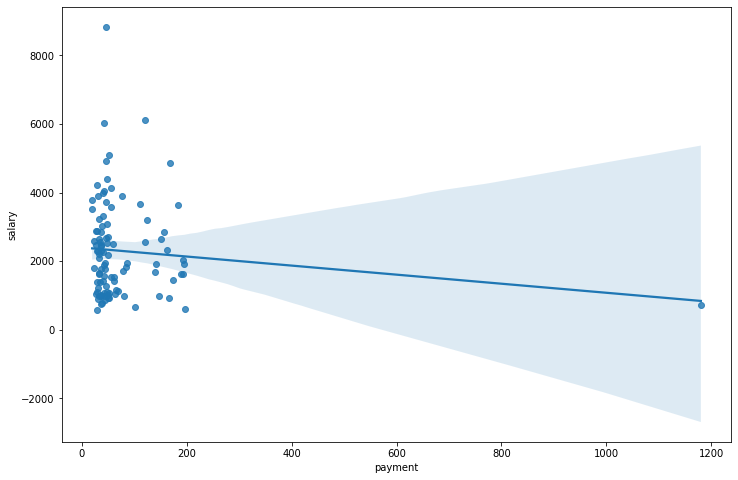

In [247]:
plt.figure(figsize=(12, 8))
sns.regplot(x="payment",y= "salary", fit_reg=True, data=df)

<AxesSubplot:xlabel='average_expenditure', ylabel='salary'>

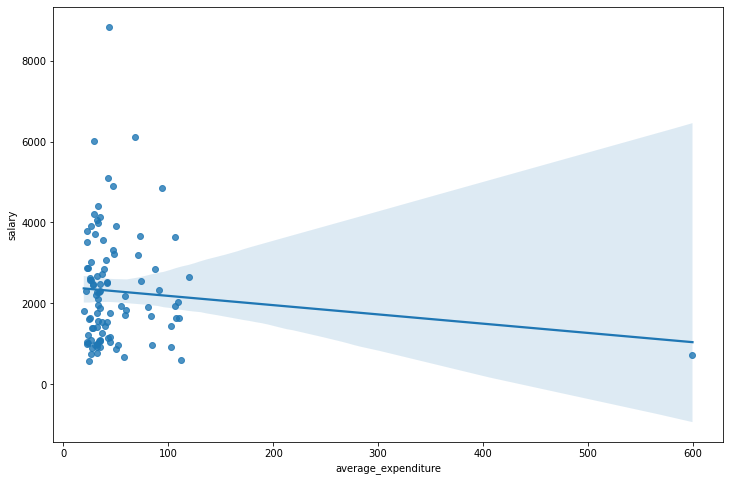

In [248]:
plt.figure(figsize=(12, 8))
sns.regplot(x="average_expenditure",y= "salary", fit_reg=True, data=df)

Combine all the expenditure and see the correlation it has with the salary.

In [184]:
df['gender_int']=(df['gender']=='F').astype(int)

In [185]:
df_corr=df.drop(['gender', 'customer_id'], axis=1)

<AxesSubplot:>

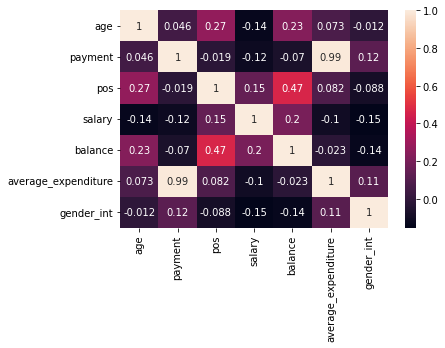

In [186]:
sns.heatmap(df_corr.corr(), annot=True)

In [187]:
#average number of weekly transactions
avg_no_weekly_trans = []
for id_ in unique_id:
    array = anz_df.loc[anz_df.customer_id == id_, "date"]
    avg_no_weekly_trans.append(round(len(array)/array.nunique()*7))
avg_no_weekly_trans[:5]

[48, 29, 24, 14, 21]

In [188]:
#maximum amount transacted
max_amount = []
for id_ in unique_id:
    array = anz_df.loc[anz_df.customer_id == id_, "amount"]
    max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

In [190]:
#number of large transactions
no_large_trans = []
for id_ in unique_id:
    count = 0
    array = anz_df.loc[anz_df.customer_id == id_, "amount"]
    for amount in array:
        if amount > 100:
            count += 1
    no_large_trans.append(count)
len(no_large_trans)

100

In [201]:
features_df = pd.DataFrame({"customer_id": unique_id, 
                            "avg_no_weekly_trans": avg_no_weekly_trans, 
                            "max_amount": max_amount, 
                            "no_large_trans": no_large_trans
                            })
len(features_df)

100

In [227]:
merged_df = pd.merge(features_df, df.drop(['gender', 'salary'], axis=1), on ='customer_id')
final_df=pd.merge(merged_df,salary_df[['annual_salary','customer_id']], on='customer_id')

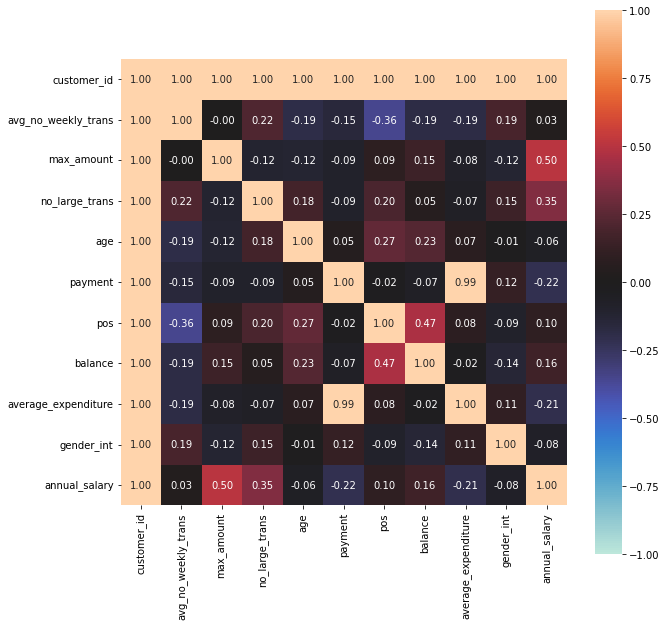

In [229]:
complete_correlation2= associations(final_df, filename= 'complete_correlation2.png', figsize=(10,10))

## **Preprocessing**
### **Train test split**

In [231]:
X = final_df.drop(["customer_id", "annual_salary"], axis = 1)
Y = final_df.annual_salary
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (100, 9)
Y shape:  (100,)


In [232]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (70, 9)
Y_train shape:  (70,)
X_test shape:  (30, 9)
Y_test shape:  (30,)


In [233]:
# Crete column transformer 

scaler = StandardScaler()
column_transform = make_column_transformer((scaler, ["avg_no_weekly_trans", "max_amount", "no_large_trans", 'age', 'payment', 'pos', 'balance', 'average_expenditure']))

### **Linear Regression**

In [235]:
# Instantiate model and pipeline
lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

In [236]:
# Fit pipeline and make predictions 
lm_pipeline.fit(X_train, Y_train)
lm_pred = lm_pipeline.predict(X_test)

In [245]:
# RMSE

print("RMSE: ", round(np.sqrt(mean_squared_error(Y_test, lm_pred))))

RMSE:  22750


In [242]:
#r2 score
from sklearn.metrics import r2_score
print('Coefficient of determination: ', r2_score(Y_test, lm_pred))

Coefficient of determination:  0.2479563929961759


### **Decision Tree**

In [238]:
# Instantiate model and pipeline 
tree = DecisionTreeRegressor()
tree_pipeline = make_pipeline(column_transform, tree)

In [239]:
# Fit pipeline and make predictions 
tree_pipeline.fit(X_train, Y_train)
tree_pred = tree_pipeline.predict(X_test)

In [240]:
# RMSE
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, Y_test))))

RMSE:  22075


In [246]:
print('Coefficient of determination: ', r2_score(Y_test, tree_pred))

Coefficient of determination:  0.291928589706942


The results show that we can't predict the annual salary with the state and amount of data that was given. The decision tree model performed better with a coefficient of determination of almost 30% which means that the training data only fit the model by 30%. The linear regression model has a coefficient of determination of 24.7%. 
So, these models can't be used for annual salary prediction, and can be improved by increasing the amount of training data, and a better selection of predictor features.